# Работа с контекстуализированными моделями

В этом ноутбуке производилась проверка влияния вариативности на работу контекстуализированных моделей

In [8]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
from transformers import pipeline
from collections import defaultdict

In [9]:
model = pipeline('fill-mask', model='bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
pred = model("I love pizza and [MASK].")
pred

[{'score': 0.18336044251918793,
  'token': 10733,
  'token_str': 'pizza',
  'sequence': 'i love pizza and pizza.'},
 {'score': 0.12329741567373276,
  'token': 5404,
  'token_str': 'beer',
  'sequence': 'i love pizza and beer.'},
 {'score': 0.050967153161764145,
  'token': 4511,
  'token_str': 'wine',
  'sequence': 'i love pizza and wine.'},
 {'score': 0.045108597725629807,
  'token': 24857,
  'token_str': 'pasta',
  'sequence': 'i love pizza and pasta.'},
 {'score': 0.03131162002682686,
  'token': 8808,
  'token_str': 'cheese',
  'sequence': 'i love pizza and cheese.'}]

In [11]:
bert_dict = defaultdict(lambda : defaultdict(list))

In [12]:
with open("subtitles_raw/en_raw_0-900.txt", "rt", encoding="utf-8") as f:
    en_all = [line.strip() for line in f]

with open("subtitles_raw/ru_raw_0-900.txt", "rt", encoding="utf-8") as f:
    ru_all = [line.strip() for line in f]

In [13]:
with open("corpora/subtitles/ru_subtitles_spacy_dump.bin", "rb") as f:
    restored_bytes_data = f.read()

nlp = spacy.blank("ru")
doc_bin = DocBin().from_bytes(restored_bytes_data)
ru_all_docs = list(doc_bin.get_docs(nlp.vocab))

In [14]:
with open("corpora/subtitles/en_subtitles_spacy_dump.bin", "rb") as f:
    restored_bytes_data = f.read()

nlp = spacy.blank("en")
doc_bin = DocBin().from_bytes(restored_bytes_data)
en_all_docs = list(doc_bin.get_docs(nlp.vocab))

In [15]:
def find_lines_with_word(original_word: str, docs) -> list:
    indexes = []
    for i, sentence in enumerate(docs):
        for token in sentence:
            if token.lemma_.lower() == original_word:
                indexes.append(i)
                break
    return indexes

In [16]:
# indexes = []
# for original_word in common:
#     indexes += find_lines_with_word(original_word, ru_all_docs)
# len(indexes)

In [17]:
def fill_bert_dict_for_one_word(original_word: str, aligned_text: list):
    MASK_TOKEN = '[MASK]'
    bert_word_dict = defaultdict(list)
    for line_idx, ru_doc in tqdm(enumerate(ru_all_docs)):
        if len(aligned_text[line_idx]) == 0:
            continue
        ru_token_idx = -1;
        for j, token in enumerate(ru_doc):
            if token.lemma_.lower() == original_word:
                if ru_token_idx != -1: 
                    ru_token_idx = -1
                    break
                else:
                    ru_token_idx = j
        if ru_token_idx != -1:
            en_token_idx = -1
            en_tokens = [token.text for token in en_all_docs[line_idx]]
            # print(line_idx)
            for src, tgt in aligned_text[line_idx]:
                if src == ru_token_idx:
                    if en_token_idx != -1:
                        en_token_idx = -1
                        break
                    else:
                        en_token_idx = tgt
            if en_token_idx != -1:
                en_tokens[en_token_idx] = MASK_TOKEN
                pred = model(' '.join(en_tokens))
                bert_word_dict[str(line_idx)] = pred
    return bert_word_dict

In [18]:
with open("corpora/subtitles/numerical_alignment/subtitles_inter.txt", "rt", encoding="utf-8") as file:
    aligned_inter = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/numerical_alignment/subtitles_itermax.txt", "rt", encoding="utf-8") as file:
    aligned_itermax = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/numerical_alignment/subtitles_mwmf.txt", "rt", encoding="utf-8") as file:
    aligned_mwmf = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

In [20]:
bert_word_dict = fill_bert_dict_for_one_word("новый", aligned_inter)
bert_word_dict

900000it [05:17, 2832.29it/s] 


defaultdict(list,
            {'374': [{'score': 0.2799505293369293,
               'token': 2047,
               'token_str': 'new',
               'sequence': "shouldn't you be over there with your new friends?"},
              {'score': 0.10067027807235718,
               'token': 2060,
               'token_str': 'other',
               'sequence': "shouldn't you be over there with your other friends?"},
              {'score': 0.08709819614887238,
               'token': 2190,
               'token_str': 'best',
               'sequence': "shouldn't you be over there with your best friends?"},
              {'score': 0.06691211462020874,
               'token': 2214,
               'token_str': 'old',
               'sequence': "shouldn't you be over there with your old friends?"},
              {'score': 0.03306974843144417,
               'token': 2210,
               'token_str': 'little',
               'sequence': "shouldn't you be over there with your little friends?"}],
   

In [21]:
len(bert_word_dict.keys())

2185

In [22]:
with open("subtitles_raw/en_raw_0-900.txt", "rt", encoding="utf-8") as f:
    en_corpus_raw = [line.strip() for line in f]

with open("subtitles_raw/ru_raw_0-900.txt", "rt", encoding="utf-8") as f:
    ru_corpus_raw = [line.strip() for line in f]

In [23]:
def fill_bert_dict_for_one_word_with_n_nearby_sentences(original_word: str, aligned_text: list, n=3):
    MASK_TOKEN = '[MASK]'
    bert_word_dict = defaultdict(list)
    for line_idx, ru_doc in tqdm(enumerate(ru_all_docs)):
        if len(aligned_text[line_idx]) == 0:
            continue
        ru_token_idx = -1;
        for j, token in enumerate(ru_doc):
            if token.lemma_.lower() == original_word:
                if ru_token_idx != -1: 
                    ru_token_idx = -1
                    break
                else:
                    ru_token_idx = j
        if ru_token_idx != -1:
            en_token_idx = -1
            en_tokens = [token.text for token in en_all_docs[line_idx]]
            for src, tgt in aligned_text[line_idx]:
                if src == ru_token_idx:
                    if en_token_idx != -1:
                        en_token_idx = -1
                        break
                    else:
                        en_token_idx = tgt
            if en_token_idx != -1:
                en_tokens[en_token_idx] = MASK_TOKEN

                area = ''
                for area_idx in range(1, n + 1):
                    area += en_corpus_raw[line_idx - area_idx] + ''
                area += ' '.join(en_tokens) + ''
                for area_idx in range(1, n + 1):
                    area += en_corpus_raw[line_idx + area_idx] + ''
                
                pred = model(area)
                bert_word_dict[str(line_idx)] = pred
    return bert_word_dict

In [24]:
bert_word_dict_area = fill_bert_dict_for_one_word_with_n_nearby_sentences("новый", aligned_inter)
bert_word_dict_area

900000it [09:47, 1532.39it/s]


defaultdict(list,
            {'374': [{'score': 0.21883031725883484,
               'token': 2047,
               'token_str': 'new',
               'sequence': "i came back. nick, i'm back. while he was gone, i kept hoping nick would forgive him and think about what i'd said, but... it seemed like his mind was made up. shouldn't you be over there with your new friends? nick, come on! the only reason i did it is'cause i was set up. it doesn't matter why you did it."},
              {'score': 0.11188266426324844,
               'token': 2060,
               'token_str': 'other',
               'sequence': "i came back. nick, i'm back. while he was gone, i kept hoping nick would forgive him and think about what i'd said, but... it seemed like his mind was made up. shouldn't you be over there with your other friends? nick, come on! the only reason i did it is'cause i was set up. it doesn't matter why you did it."},
              {'score': 0.09568480402231216,
               'token': 2190

In [25]:
variety_dict = defaultdict(list)
for key, value in bert_word_dict_area.items():
    variety_dict[value[0]["token_str"].lower()].append(key)

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_variety_pie(variety_dict, original_word: str):
    variety_dict_items = list(variety_dict.items())
    variety_dict_items.sort(key=lambda x: -len(x[1]))

    translations = []
    # translations.append("other")
    number_of_matches = []
    pre_number_of_matches = [len(x[1]) for x in variety_dict_items]
    total_words = sum(pre_number_of_matches)
    other_matches = 0
    for key, val in variety_dict_items:
        translations.append(key)
        number_of_matches.append(len(val))

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    plt.pie(number_of_matches, autopct = lambda pct: func(pct, number_of_matches), labels = translations)

    plt.title(original_word)
    plt.legend(bbox_to_anchor=(0.85,1.025), loc="upper left")

    # show plot
    plt.show()

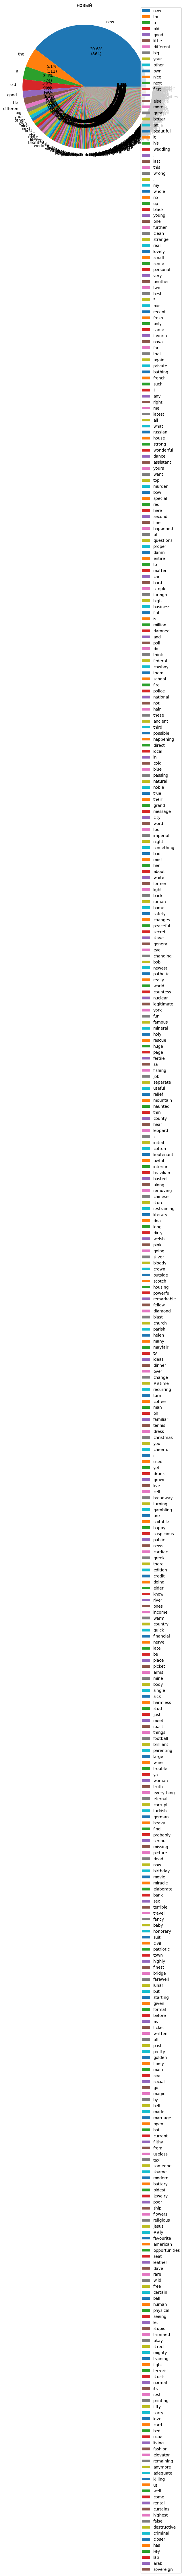

In [27]:
plot_variety_pie(variety_dict, "новый")